MODELOS DE RNN (LSTM) PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO

Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

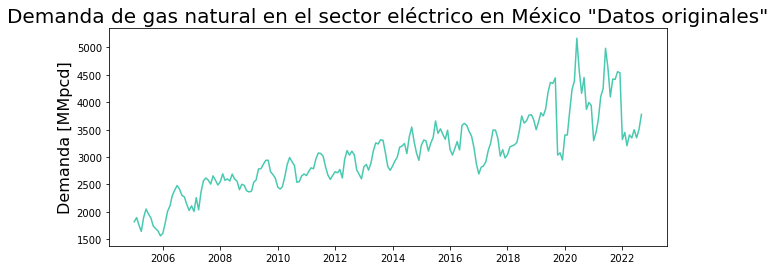

In [7]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

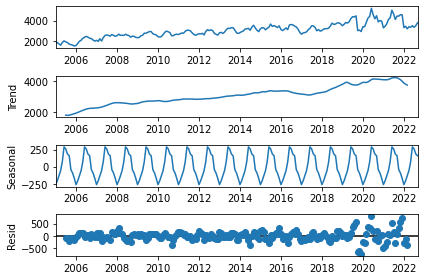

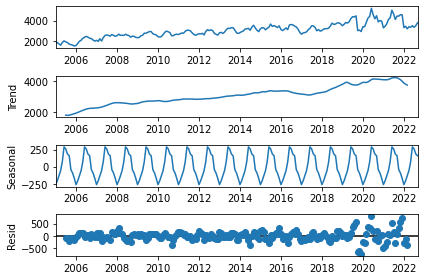

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [9]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se define y entrena el MinMaxScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(csv_demanda_electrico_original_train_data)

MinMaxScaler()

Se aplica la escalación de data

In [14]:
csv_demanda_electrico_scaled_train = MinMax_scaler.transform(csv_demanda_electrico_original_train_data)
csv_demanda_electrico_scaled_test = MinMax_scaler.transform(csv_demanda_electrico_original_test_data)
csv_demanda_electrico_scaled_train

array([[0.07168816],
       [0.09268731],
       [0.0567961 ],
       [0.02265413],
       [0.09274552],
       [0.13604118],
       [0.11118319],
       [0.09111549],
       [0.04937779],
       [0.03740758],
       [0.02438673],
       [0.        ],
       [0.0137139 ],
       [0.06801505],
       [0.1236108 ],
       [0.15172886],
       [0.20456354],
       [0.23227963],
       [0.2549393 ],
       [0.23621611],
       [0.20444988],
       [0.1976359 ],
       [0.15896421],
       [0.12890563],
       [0.15187856],
       [0.12359139],
       [0.19350815],
       [0.13185522],
       [0.2219949 ],
       [0.27894624],
       [0.2931425 ],
       [0.28230888],
       [0.26220515],
       [0.30390127],
       [0.28192632],
       [0.25737049],
       [0.27370963],
       [0.31419986],
       [0.28129981],
       [0.28810548],
       [0.27775144],
       [0.31287199],
       [0.28763698],
       [0.27746314],
       [0.23393184],
       [0.26135964],
       [0.25557967],
       [0.228

When using a RNN for multi-step time series forecasting there are two main approaches to take: 
a) Direct Multi-Step Forecast:Prefict all future time steps directly using a single Dense output layer.
b) Auto-Regresive Prediction: Predict one step at a time and feed the predicted value back into the model to predict the next step
Source: Spencer Pao, RNN Appliying Understanding Recurrent NN in Python 

Se generan sets de 12 datos para con ellos predecir el 13, y asñi los siguientes 12 para predecir el 13, etc 

In [16]:

from keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# We do the same thing, but now instead for 12 months
n_input = 12
demanda_electrico_scaled_train_generator = TimeseriesGenerator(csv_demanda_electrico_scaled_train, csv_demanda_electrico_scaled_train, length=n_input, batch_size=1)
demanda_electrico_scaled_train_generator

In [22]:
X,y = demanda_electrico_scaled_train_generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.07168816 0.09268731 0.0567961  0.02265413 0.09274552 0.13604118
 0.11118319 0.09111549 0.04937779 0.03740758 0.02438673 0.        ]
Predict this y: 
 [[0.0137139]]


In [23]:
X,y = demanda_electrico_scaled_train_generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.09268731 0.0567961  0.02265413 0.09274552 0.13604118 0.11118319
 0.09111549 0.04937779 0.03740758 0.02438673 0.         0.0137139 ]
Predict this y: 
 [[0.06801505]]


Se importan las librerias necesarias y se define la RNN(LSTM)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [26]:
n_input = 12
n_features = 1
# define model
model_LSTM_and_Dense = Sequential()
model_LSTM_and_Dense.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_and_Dense.add(Dense(1))
model_LSTM_and_Dense.compile(optimizer='adam', loss='mse')

In [27]:
model_LSTM_and_Dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo RNN(LSTM) + Dense Layers con el demanda_electrico_scaled_train_generator

In [28]:
model_LSTM_and_Dense.fit(demanda_electrico_scaled_train_generator, epochs=50)

Epoch 1/50
189/189 [==============================] - 8s 7ms/step - loss: 0.0172
Epoch 2/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0107
Epoch 3/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0087
Epoch 4/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0073
Epoch 5/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 6/50
189/189 [==============================] - 1s 7ms/step - loss: 0.0058
Epoch 7/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 8/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0053
Epoch 9/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0048
Epoch 10/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0045
Epoch 11/50
189/189 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 12/50
189/189 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 13/50
189/189 [====

Se grafica la perdida por epoch 

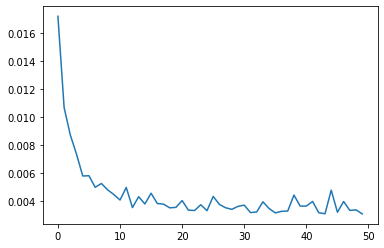

In [29]:
loss_per_epoch = model_LSTM_and_Dense.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 memes usando el modelo model_LSTM_and_Dense

In [30]:
csv_demanda_electrico_scaled_test 

array([[0.791877  ],
       [0.83064572],
       [0.82552553],
       [0.48783713],
       [0.52361191],
       [0.45629267],
       [0.51076016],
       [0.49595403],
       [0.53716779],
       [0.49621461],
       [0.5393079 ],
       [0.61469691]])

Se toman los ultimos 12 elementos de los datos de train y se almacenan en un batch

In [34]:
demanda_electrico_scaled_train_batch = csv_demanda_electrico_scaled_train[-12:]
demanda_electrico_scaled_train_batch

array([[0.64003449],
       [0.67506632],
       [0.65981388],
       [0.48164966],
       [0.52483443],
       [0.58778751],
       [0.7051942 ],
       [0.74375778],
       [0.94934147],
       [0.85129557],
       [0.70352813],
       [0.79378425]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [35]:
demanda_electrico_scaled_train_batch_reshaped = demanda_electrico_scaled_train_batch.reshape(1,n_input, n_features)
demanda_electrico_scaled_train_batch_reshaped

array([[[0.64003449],
        [0.67506632],
        [0.65981388],
        [0.48164966],
        [0.52483443],
        [0.58778751],
        [0.7051942 ],
        [0.74375778],
        [0.94934147],
        [0.85129557],
        [0.70352813],
        [0.79378425]]])

Intentamos predecir el sigueinte valor dado el primet batch de 12. Esto equivaldria a predecir el primer valor de los datos de test, dados los 12 anteriores

In [36]:
model_LSTM_and_Dense.predict(demanda_electrico_scaled_train_batch_reshaped)

1/1 [==============================] - 0s 316ms/step


array([[0.7742124]], dtype=float32)

Y se compara el valor de forecast del modelo model_LSTM_and_Dense con los datos de test de la demanda de gasd natural en sector eléctrico escalado 

In [37]:
csv_demanda_electrico_scaled_test[0]

array([0.791877])

Ahora ser hará una función que irá formando batch de 12 para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo 

In [38]:
n_input = 12
n_features = 1

In [50]:
test_predictions = []

first_eval_batch = demanda_electrico_scaled_train_batch = csv_demanda_electrico_scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(csv_demanda_electrico_scaled_test)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_and_Dense.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


In [52]:
test_predictions 

[array([0.7742124], dtype=float32),
 array([0.7826144], dtype=float32),
 array([0.78926706], dtype=float32),
 array([0.7888018], dtype=float32),
 array([0.8048432], dtype=float32),
 array([0.83712333], dtype=float32),
 array([0.88537925], dtype=float32),
 array([0.9395298], dtype=float32),
 array([0.9995394], dtype=float32),
 array([1.0104098], dtype=float32),
 array([0.99225175], dtype=float32),
 array([0.9745617], dtype=float32)]

In [53]:
csv_demanda_electrico_scaled_test

array([[0.791877  ],
       [0.83064572],
       [0.82552553],
       [0.48783713],
       [0.52361191],
       [0.45629267],
       [0.51076016],
       [0.49595403],
       [0.53716779],
       [0.49621461],
       [0.5393079 ],
       [0.61469691]])

In [45]:
true_predictions = MinMax_scaler.inverse_transform(test_predictions)
true_predictions

array([[4353.78872049],
       [4384.09713477],
       [4408.0951842 ],
       [4406.41680647],
       [4464.28278123],
       [4580.72663298],
       [4754.79973211],
       [4950.13636773],
       [5166.60839314],
       [5205.82128288],
       [5140.31982899],
       [5076.50664335]])

In [47]:
csv_demanda_electrico_original_test_data['Demanded_Gas']

Date
2021-10-01    4417.51
2021-11-01    4557.36
2021-12-01    4538.89
2022-01-01    3320.75
2022-02-01    3449.80
2022-03-01    3206.96
2022-04-01    3403.44
2022-05-01    3350.03
2022-06-01    3498.70
2022-07-01    3350.97
2022-08-01    3506.42
2022-09-01    3778.37
Name: Demanded_Gas, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

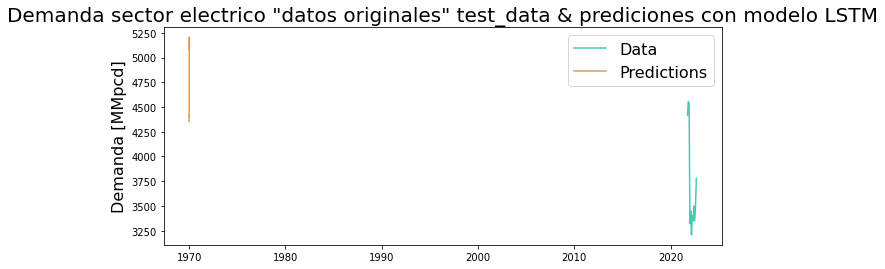

In [49]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'], color='#48C9B0')
plt.plot(true_predictions, color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo LSTM', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)